# Markov Chains

In diesem Tutorial nutzen wir Markov-Ketten, um Melodien zu generieren. Wenn du vorher noch nie mit Python gearbeitet hast, empfehlen wir zunächst die Einführung in Python mit Mozarts Würfelspiel zu machen:

https://github.com/langMatthias/ai-intro/tree/main/exercises/medium/01%20-%20Einf%C3%BChrung%20in%20Python

## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import music21
from google.colab import files


## Midi-Pitches
Tonhöhen werden in MIDI als ganze Zahlen (sog. Integers) abgespeichert. Die tiefste Note ist 0, die höchste 127.
Diese Zahlen können wir nutzen um zu zählen, welcher Ton wie oft auf welchen anderen Ton folgt.
Dazu nehmen wir uns zunächst zwei einfache Melodien.

In [2]:
brother_john = [60, 62, 64, 60, 60, 62, 64, 60]
little_lamb = [64, 62, 60, 62, 64, 64, 64]

## Übergangs-Wahrscheinlichkeiten
Diese beiden Listen repräsentieren zwei kurze Melodien. Nun müssen wir zählen, wie oft welcher Ton auf welchen anderen Ton folgt. Dazu erstellen wir eine Tabelle mit der Python-Bibliothek `pandas`. Vervollständige folgende Funktion, bei der die Übergänge von einem Ton in den anderen gezählt werden. Dabei entsprechen die Spalten den aktuellen Tönen und die Zeilen den jeweils darauf folgenden Tönen. Folgt also zum Beispiel auf einen Pitch 60 der Pitch 62, so wird der Eintrag in der Spalte für den 60. Ton in der Zeile für den 62. Ton um 1 erhöht. Der Einfachheit halber kann die Tabelle alle Töne von 0 bis zum höchsten verwendeten Ton abdecken. Ist also der Ton 64 der höchste Ton, enthält die Tabelle die Spalten und Zeilen von 0-64 und hat damit 65 Spalten und 65 Zeilen.

In [3]:
def make_table(allSeq):
 # find the highest note
 n = max([ max(s) for s in allSeq ]) + 1
 # fill the table with zeros
 arr = np.zeros((n,n), dtype=int)
 # iterate over all sequences
 for s in allSeq:
  # iterate over all notes
  for i,j in zip(s[1:],s[:-1]):
    # add 1 to the count of the transition from one note to another
    ind = (i,j)
    arr[ind] += 1
 return pd.DataFrame(arr).rename_axis(index='Next', columns='Current')

Um zu testen, ob die Spalte korrekt erstellt wurde, gibt es hier zwei Tests

In [4]:
transitions = make_table([brother_john, little_lamb])
assert transitions.loc[62,60] == 3, f"Expected the count of 3 for the transition from 60 to 62, but got {transitions.loc[62,60]}"
assert transitions.loc[60,62] == 1, f"Expected the count of 1 for the transition from 62 to 60, but got {transitions.loc[60,62]}"
print("Der Test war erfolgreich.")

Diese Tabelle wird später die Grundlage für die Markov-Kette sein. Um sich die Tabelle anzusehen, können wir die Funktion `show_table` nutzen.

In [ ]:
def show_table(transitions):
    """
    Show a transition table as a heatmap
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    simplified_df = transitions[transitions != 0].dropna(how='all', axis=0).dropna(how='all', axis=1).fillna(0).astype(int)
    sns.heatmap(simplified_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()
    display(simplified_df)

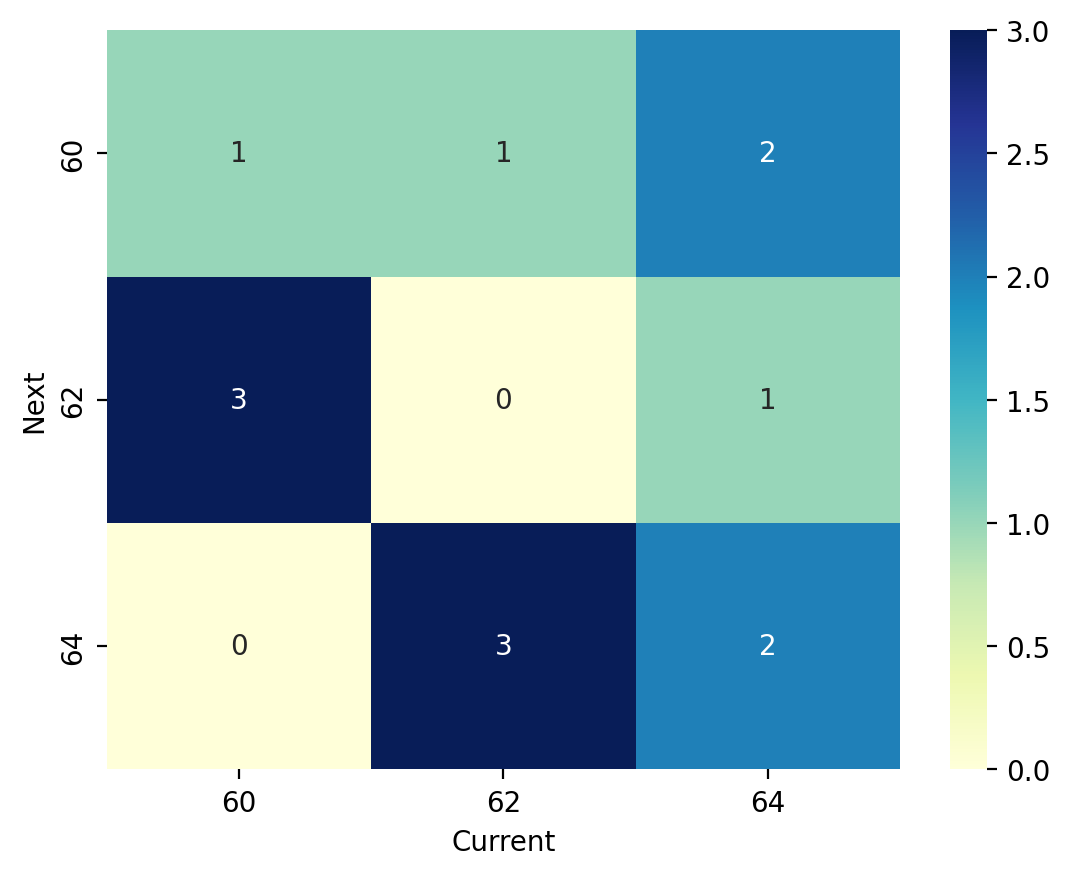

Current,60,62,64
Next,,,
60,1,1,2
62,3,0,1
64,0,3,2


In [ ]:
show_table(transitions)

## Markov-Kette
Nun benötigen wir eine Funktion, die uns anhand des vorangegangen Tones und den Übergangs-Wahrscheinlichkeiten in der Tabelle, den nächsten Ton voraussagt. Vervollständige die Funktion `get_next_term()` welche eine Spalte der Tabelle übergeben bekommt und nach den Gewichtungen, die in dieser Spalte gespeichert sind, den nächsten Ton auswählt.

Tipp: Hierfür könnte die Funktion random.choices() hilfreich sein: https://docs.python.org/3/library/random.html#random.choices

In [44]:
def get_next_term(t_s):
 # get the index of the next term based on the weights in the transition table
 return random.choices(t_s.index, t_s)[0]


In [48]:
for i in range(100):
  test_term = get_next_term(transitions[60])
  assert test_term in [60,62], f"Der Übergang von Pitch 60 kann nur zu Pitches 60 oder 62 führen. Hier wurde allerdings Pitch {test_term} erreicht."
print("Der Test war erfolgreich.")

Der Test war erfolgreich.


Um diese Funktion nun mehrmals aufzurufen, können wir eine Schleife nutzen. Diese Schleife wird so lange laufen, bis wir eine gewünschte Länge erreicht haben. Vervollständige dafür die Funktion `make_chain()`.

In [47]:
def make_chain(transition_table, start_note, length):
 """
 Create a Markov chain of a given length with a given starting note, based on a transition table
 """
 chain = [start_note]
 for i in range(length-1):
  chain.append(get_next_term(transition_table[chain[-1]]))
 return chain

Wenn wir nun `make_chain` aufrufen, erhalten wir eine neue Melodie, die auf den Übergangs-Wahrscheinlichkeiten der beiden gezählten Melodien basiert.

In [52]:
simple_chain = make_chain(transitions, 60, 10)
assert set(simple_chain).issubset({60,62,64}), "Not all elements of list1 are represented in list2"
print("Der Test war erfolgreich.")

Der Test war erfolgreich.


Diese Melodie können wir nun mit `save_midi_pitches` in MIDI umwandeln und abspielen. Finde dafür heraus, wie du neue MIDI-Noten in music21 erstellst und an einen music21 Stream anfügst.

https://web.mit.edu/music21/doc/usersGuide/usersGuide_04_stream1.html#usersguide-04-stream1

In [ ]:
def save_midi_pitches(midi_notes, file_path):
    """
    Saves a list of midi pitches to a midi file
    """
    midi_stream = music21.stream.Stream()
    for note in midi_notes:
        midi_note = music21.note.Note(note)
        midi_stream.append(midi_note)
    midi_stream.write('midi', file_path)

In [ ]:
save_midi_pitches(simple_chain, "simple_chain.mid")

## Längere Melodien aus MIDI-Dateien laden
Um die Übergangs-Wahrscheinlichkeiten aussagekräftiger zu machen, können wir längere Melodien aus MIDI-Dateien laden. Dazu nutzen wir die Bibliothek `music21`. Ergänze die folgende Funktion. Finde dafür heraus, wie du den MIDI-Pitch (eine Zahl von 0 bis 127) einer music21 Note erhältst und gehe dann durch das gesamte MIDI-File um sämtliche MIDI-Pitches an die Liste `midi_pitches` anzufügen.

In [53]:
def get_pitches(midi_file_path):
    """
    Returns a list of midi pitches from a midi file
    """
    midi_pitches = []
    midi_file = music21.converter.parse(midi_file_path)
    notes_to_parse = None
    parts = music21.instrument.partitionByInstrument(midi_file)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi_file.flat.notes
    for note in notes_to_parse:
        if isinstance(note, music21.note.Note):
            midi_pitches.append(note.pitch.midi)
    return midi_pitches

Mit dem folgenden Code können wir MIDI-Dateien auf den Server laden.

In [ ]:
uploaded_files = files.upload()

Saving MOZART-Würfelspiel.mid to MOZART-Würfelspiel.mid


Wir laden dann alle Tonhöhen der hochgeladenen MIDI-Dateien in eine Liste. Vervollständige den folgenden Code dafür.

In [ ]:
pitches = []
for file in uploaded_files:
    pitches.append(get_pitches(file))
    print(f"Added {file} to the list of pitches")


Added MOZART-Würfelspiel.mid to the list of pitches


Dann erstellen wir für diese Liste eine neue Tabelle. Ergänze den folgenden Code.

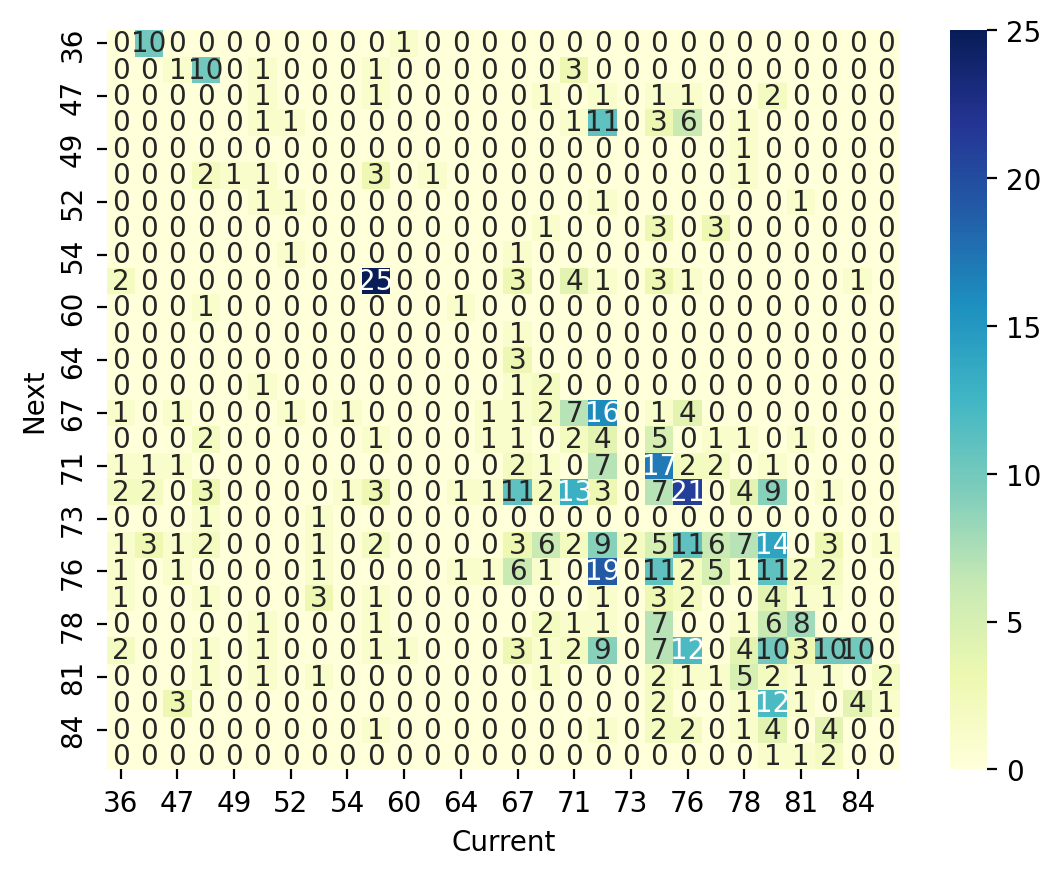

Current,36,43,47,48,49,50,52,53,54,55,...,73,74,76,77,78,79,81,83,84,86
Next,,,,,,,,,,,,,,,,,,,,,
36,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,0,1,10,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
47,0,0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,2,0,0,0,0
48,0,0,0,0,0,1,1,0,0,0,...,0,3,6,0,1,0,0,0,0,0
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
50,0,0,0,2,1,1,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0
52,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
53,0,0,0,0,0,0,0,0,0,0,...,0,3,0,3,0,0,0,0,0,0
54,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
new_transitions = make_table(pitches)
show_table(new_transitions)

Und schließlich können wir mit dieser Tabelle eine neue Melodie generieren. Und diese als MIDI abspeichern.

In [ ]:
complex_chain = make_chain(new_transitions, 60, 100)
save_midi_pitches(complex_chain, "complex_chain.mid")

Damit haben wir das Ende dieses Tutorials erreicht. Wie könntest du Markov Chains weiter einsetzen? Wie wäre es zum Beispiel Akkorde mit der music21.chord.Chord miteinander zu verbinden?

https://web.mit.edu/music21/doc/moduleReference/moduleChord.html#chord